![tracker](https://us-central1-vertex-ai-mlops-369716.cloudfunctions.net/pixel-tracking?path=statmike%2Fvertex-ai-mlops%2FMLOps&file=Vertex+AI+Pipelines+-+Introduction.ipynb)
<!--- header table --->
<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/statmike/vertex-ai-mlops/blob/main/MLOps/Vertex%20AI%20Pipelines%20-%20Introduction.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Google Colaboratory logo">
      <br>Run in<br>Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https%3A%2F%2Fraw.githubusercontent.com%2Fstatmike%2Fvertex-ai-mlops%2Fmain%2FMLOps%2FVertex%2520AI%2520Pipelines%2520-%2520Introduction.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo">
      <br>Run in<br>Colab Enterprise
    </a>
  </td>      
  <td style="text-align: center">
    <a href="https://github.com/statmike/vertex-ai-mlops/blob/main/MLOps/Vertex%20AI%20Pipelines%20-%20Introduction.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      <br>View on<br>GitHub
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/statmike/vertex-ai-mlops/main/MLOps/Vertex%20AI%20Pipelines%20-%20Introduction.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      <br>Open in<br>Vertex AI Workbench
    </a>
  </td>
</table>

# Vertex AI Piplines - Introduction

When an ML workflow has more than one step it can benefit from a pipeline.  [Vertex AI Pipelines]() is a managed service that executes [Kubeflow Pipelines (KFP)](https://www.kubeflow.org/docs/components/pipelines/v2/introduction/) and [TensorFlow Extended (TFX)](https://www.tensorflow.org/tfx/guide/understanding_tfx_pipelines) pipelines.  For this introduction the focus will be on KFP due to its vast flexibility, it was even originally developed as a simplified way of running TFX on Kubernetes - [history of Kubeflow](https://www.kubeflow.org/docs/started/introduction/#history).

This notebook based workflow will introduce KFP pipelines runninng on Vertex AI Pipelines and point to the additional detailed workflows within [this repository](./readme.md) that help with a deeper understanding.

---

**Pipelines** - The Concept

Pipelines are constructed from steps.  The steps are called **tasks** and utilize **components**.

The tasks are connected by inputs and outputs.  This forms the execution graph of the pipeline.

Inputs and outputs can be made up of **parameters** (`str`, `int`, `float`, `bool`, `dict`, `list`) as well as **artifacts**.  Artifacts are multiparameter objects that have defined schemas for machine learning objects (datasets, models, etc.) and automatically get stored as [Vertex AI ML Metadata](https://cloud.google.com/vertex-ai/docs/ml-metadata/introduction) and have lineage.

**Kubeflow Pipelines** - Constructing Pipelines

Pipelines are written in Python using the [`kfp` package](https://www.kubeflow.org/docs/components/pipelines/v2/installation/).  This SDK has decorators for multiple ways of writing [**components**](https://www.kubeflow.org/docs/components/pipelines/v2/components/) and constructing [**pipelines**](https://www.kubeflow.org/docs/components/pipelines/v2/pipelines/) from the components with features to control the execution and flow of the pipeline. Pipeline code is [**compiled**](https://www.kubeflow.org/docs/components/pipelines/v2/compile-a-pipeline/) into a YAML file using a single line command with the SDK.  

**Vertex AI Pipelines** - Executing Pipelines

The resulting YAML file is the input for [running the pipeline](https://cloud.google.com/vertex-ai/docs/pipelines/run-pipeline) with Vertex AI Pipelines.  The runs can even be scheduled with [Vertex AI Pipeline scheduler API](https://cloud.google.com/vertex-ai/docs/pipelines/schedule-pipeline-run).

The runs of a pipeline can be directly monitored, and compared, in the Vertex AI console:

**Pipeline Dashboard View In The Console: Overall Pipeline**
<p><center>
    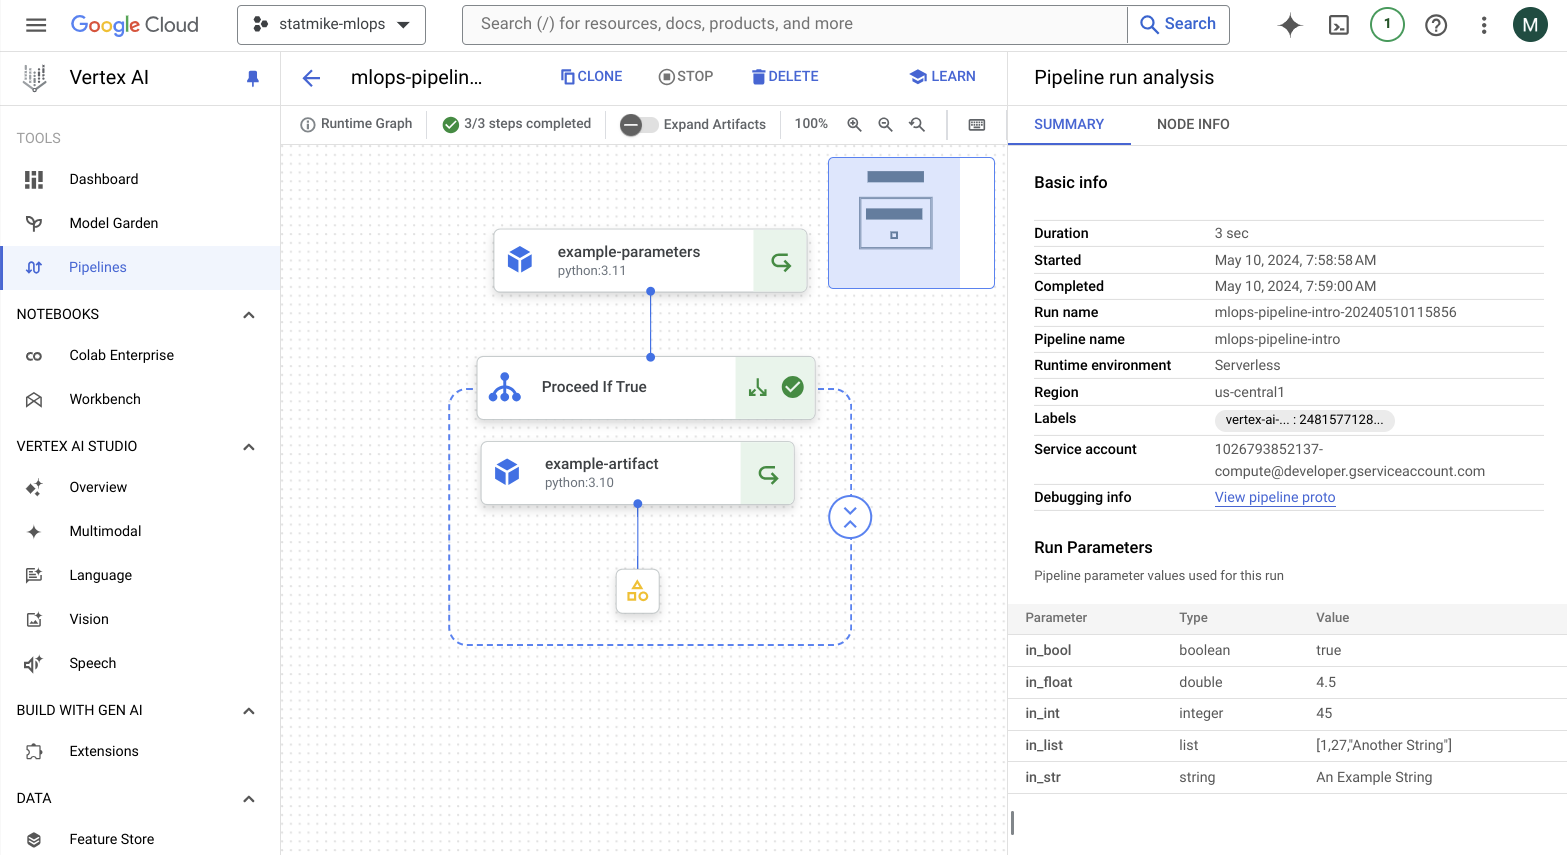
</center><p>

---
## Colab Setup

To run this notebook in Colab run the cells in this section.  Otherwise, skip this section.

This cell will authenticate to GCP (follow prompts in the popup).

In [1]:
PROJECT_ID = 'statmike-mlops-349915' # replace with project ID

In [2]:
try:
    from google.colab import auth
    auth.authenticate_user()
    !gcloud config set project {PROJECT_ID}
    print('Colab authorized to GCP')
except Exception:
    print('Not a Colab Environment')
    pass

Not a Colab Environment


---
## Installs

The list `packages` contains tuples of package import names and install names.  If the import name is not found then the install name is used to install quitely for the current user.

In [3]:
# tuples of (import name, install name, min_version)
packages = [
    ('google.cloud.aiplatform', 'google-cloud-aiplatform', '1.51.0'),
    ('kfp', 'kfp'),
]

import importlib
install = False
for package in packages:
    if not importlib.util.find_spec(package[0]):
        print(f'installing package {package[1]}')
        install = True
        !pip install {package[1]} -U -q --user
    elif len(package) == 3:
        if importlib.metadata.version(package[0]) < package[2]:
            print(f'updating package {package[1]}')
            install = True
            !pip install {package[1]} -U -q --user

## API Enablement

In [4]:
!gcloud services enable aiplatform.googleapis.com

### Restart Kernel (If Installs Occured)

After a kernel restart the code submission can start with the next cell after this one.

In [5]:
if install:
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

---
## Setup

Inputs

In [6]:
project = !gcloud config get-value project
PROJECT_ID = project[0]
PROJECT_ID

'statmike-mlops-349915'

In [7]:
REGION = 'us-central1'
EXPERIMENT = 'pipeline-intro'
SERIES = 'mlops'

# gcs bucket
GCS_BUCKET = PROJECT_ID

Packages

In [8]:
import os
import time
import importlib
from google.cloud import aiplatform
import kfp
from typing import NamedTuple

In [9]:
kfp.__version__

'2.7.0'

In [10]:
aiplatform.__version__

'1.51.0'

Clients

In [11]:
# vertex ai clients
aiplatform.init(project = PROJECT_ID, location = REGION)

parameters:

In [12]:
DIR = f"temp/{SERIES}-{EXPERIMENT}"

In [13]:
SERVICE_ACCOUNT = !gcloud config list --format='value(core.account)' 
SERVICE_ACCOUNT = SERVICE_ACCOUNT[0]
SERVICE_ACCOUNT

'1026793852137-compute@developer.gserviceaccount.com'

environment:

In [14]:
if not os.path.exists(DIR):
    os.makedirs(DIR)

---
## KFP Pipeline On Vertex AI Pipelines

An example workflows: a KFP pipeline constructed from custom components and run on Vertex AI Pipelines.

### Create Pipeline Components

These are simple Python components, specifically lightweight Python components.  

Simple component with multiple inputs of different data types and outputs a dictionary.

In [15]:
@kfp.dsl.component(
    base_image = "python:3.11",
    packages_to_install = ["pandas"]
)
def example_parameters(
    in_str: str,
    in_int: int,
    in_float: float,
    in_bool: bool,
    in_list: list
) -> dict:
    results = dict(
        ex_str = in_str,
        ex_int = in_int,
        ex_float = in_float,
        ex_bool = in_bool,
        ex_list = in_list
    )
    return results

Simple component that take input parameters and outputs an artifact.

In [16]:
@kfp.dsl.component(
    base_image = "python:3.10",
    packages_to_install = ["pandas"]
)
def example_artifact(
    metadata: dict
) -> kfp.dsl.Artifact:
    ex_artifact = kfp.dsl.Artifact(
        metadata = metadata,
        uri = 'https://www.kubeflow.org/docs/components/pipelines/v2/data-types/artifacts/#artifact-types'
    )
    return ex_artifact

### Create Pipeline

In [17]:
@kfp.dsl.pipeline(
    name = f'{SERIES}-{EXPERIMENT}',
    description = 'An introduction pipeline',
    pipeline_root = f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/pipeline_root'
)
def intro_pipeline(
    in_str: str,
    in_int: int,
    in_float: float,
    in_bool: bool,
    in_list: list
) -> dict:
    
    task1 = example_parameters(
        in_str = in_str,
        in_int = in_int,
        in_float = in_float,
        in_bool = in_bool,
        in_list = in_list
    )
    
    with kfp.dsl.If(in_bool == True, name = 'Proceed If True'):
        task2 = example_artifact(metadata = task1.output)

    return task1.output

### Compile Pipeline

In [18]:
kfp.compiler.Compiler().compile(
    pipeline_func = intro_pipeline,
    package_path = f'{DIR}/{SERIES}-{EXPERIMENT}.yaml'
)

### Create Pipeline Job (With Vertex AI SDK)

The compiled pipeline file can be submitted for running with the console or the SDK (shown here).  Check out the details in the documentation [here](https://cloud.google.com/vertex-ai/docs/pipelines/run-pipeline#create_a_pipeline_run) for an overview with the console.


In [19]:
pipeline_job = aiplatform.PipelineJob(
    display_name = f"{SERIES}-{EXPERIMENT}",
    template_path = f"{DIR}/{SERIES}-{EXPERIMENT}.yaml",
    parameter_values = dict(
        in_str = 'An Example String',
        in_int = 45,
        in_float = 4.5,
        in_bool = True,
        in_list = [1, 27, 'Another String']
    ),
    pipeline_root = f'gs://{GCS_BUCKET}/{SERIES}/{EXPERIMENT}/pipeline_root',
    enable_caching = None # True (enabled), False (disable), None (defer to component level caching) 
)

### Submit Pipeline Job (On Vertex AI Pipelines)

In [20]:
response = pipeline_job.submit(
    service_account = SERVICE_ACCOUNT
)

Creating PipelineJob
PipelineJob created. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-intro-20240513162405
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-intro-20240513162405')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-intro-20240513162405?project=1026793852137


In [21]:
print(f'The Dashboard can be viewed here:\n{pipeline_job._dashboard_uri()}')

The Dashboard can be viewed here:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/mlops-pipeline-intro-20240513162405?project=1026793852137


In [22]:
pipeline_job.wait()

PipelineJob run completed. Resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-intro-20240513162405


---
## Results: Vertex AI Console And SDK

As soon as the job is submitted the response gives a link to the the dashboard view in the console for Vertex AI Pipelines.  Using this link, or navigating directly though Vertex AI, gives a dashboard view of the pipeline as it is running with progress indicatiors for each task.  This information call also be retrieved using the Vertex AI SDK. Both approaches will be covered in this section for:
- Pipeline Run
- Pipeline Run Tasks Level
- Pipeline IO Artifacts
- Artifact Lineage In Vertex AI ML Metadata

### Pipeline Run Overview

**Pipeline Dashboard View In The Console: Overall Pipeline**
<p><center>
    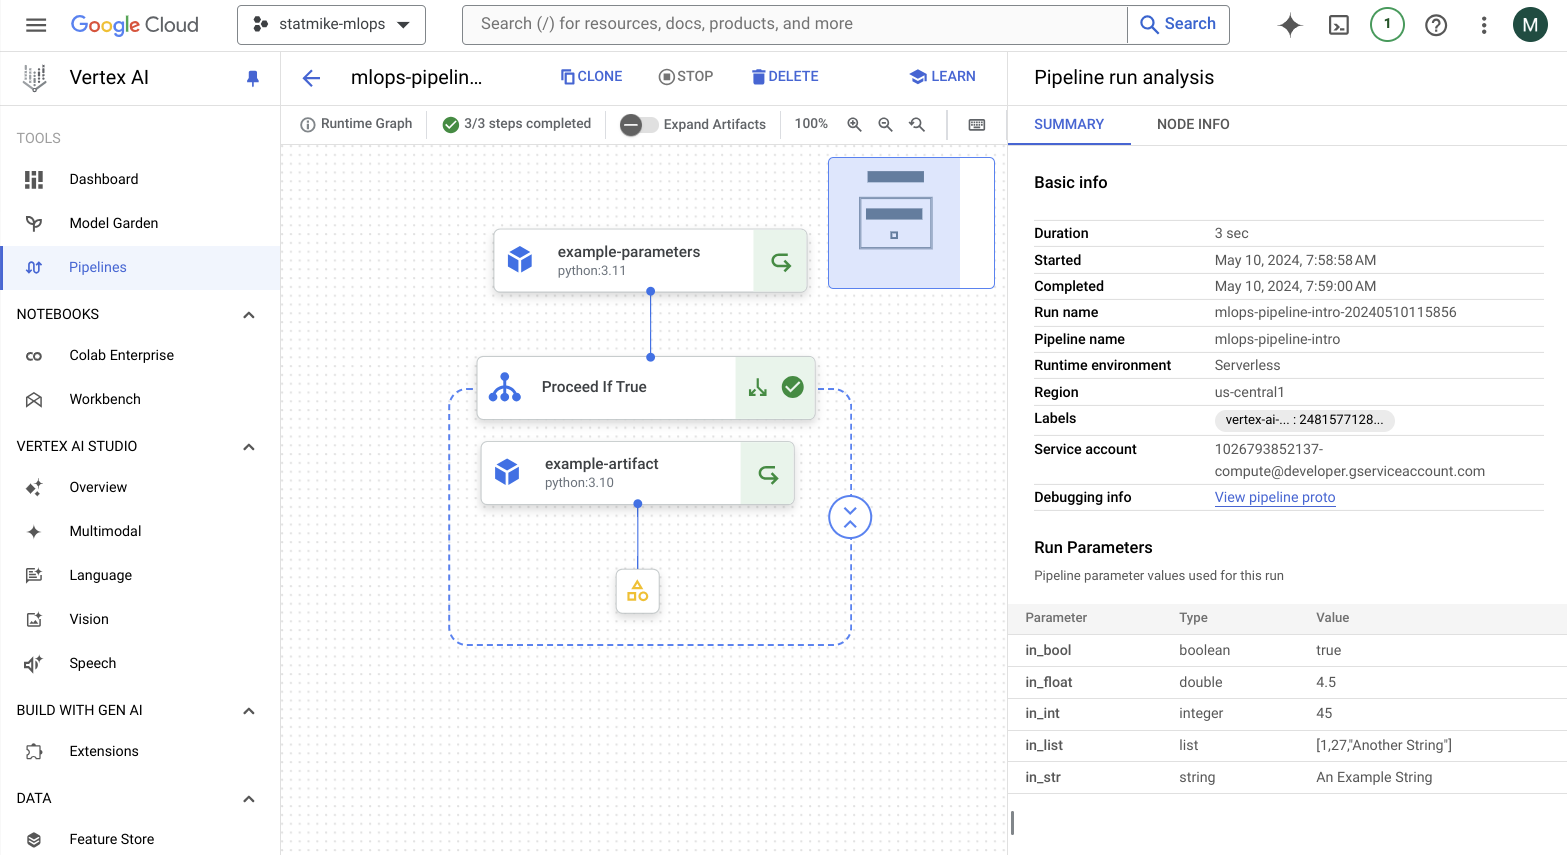
</center><p>

Note that:
- each node, or tasks, is displayed.
- the connections between nodes are visual and reflect the input/output dependencies
- the node purpose is reflected with an icon and the status is reflected with an icon and color coding
- a summary of the pipeline run is provide on the right and includes all the pipelines inputs parameters.

    
The same information can be retrieved with the Vertex AI SDK as follows.
- SDK Reference: [`aiplatform.PipelineJob`](https://cloud.google.com/python/docs/reference/aiplatform/latest/google.cloud.aiplatform.PipelineJob)

#### Retrieve Latest Run: By Display Name

In [98]:
aiplatform.PipelineJob.list(
    project = PROJECT_ID,
    location = REGION,
    filter = f'display_name="{SERIES}-{EXPERIMENT}"',
    order_by='update_time desc'
)[0]

resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-intro-20240510115856

#### Review PipelineJob Object

In [27]:
pipeline_job

resource name: projects/1026793852137/locations/us-central1/pipelineJobs/mlops-pipeline-intro-20240513162405

In [23]:
type(pipeline_job)

google.cloud.aiplatform.pipeline_jobs.PipelineJob

In [24]:
pipeline_job.state

<PipelineState.PIPELINE_STATE_SUCCEEDED: 4>

In [25]:
pipeline_job.display_name

'mlops-pipeline-intro'

In [26]:
pipeline_job.name

'mlops-pipeline-intro-20240513162405'

In [37]:
pipeline_job.to_dict().keys()

dict_keys(['name', 'displayName', 'createTime', 'startTime', 'endTime', 'updateTime', 'pipelineSpec', 'state', 'jobDetail', 'labels', 'runtimeConfig', 'serviceAccount'])

In [38]:
pipeline_job.to_dict()['pipelineSpec'].keys()

dict_keys(['deploymentSpec', 'pipelineInfo', 'schemaVersion', 'root', 'deploymentConfig', 'components', 'defaultPipelineRoot', 'sdkVersion'])

### Pipeline Run: Task Overview

Each component used in the pipeline created a task.  These task can be retrieved, reviewed, and even examine for input/ouput values of parameters.

**Pipeline Dashboard View In The Console: Task Level Details**
<p><center>
    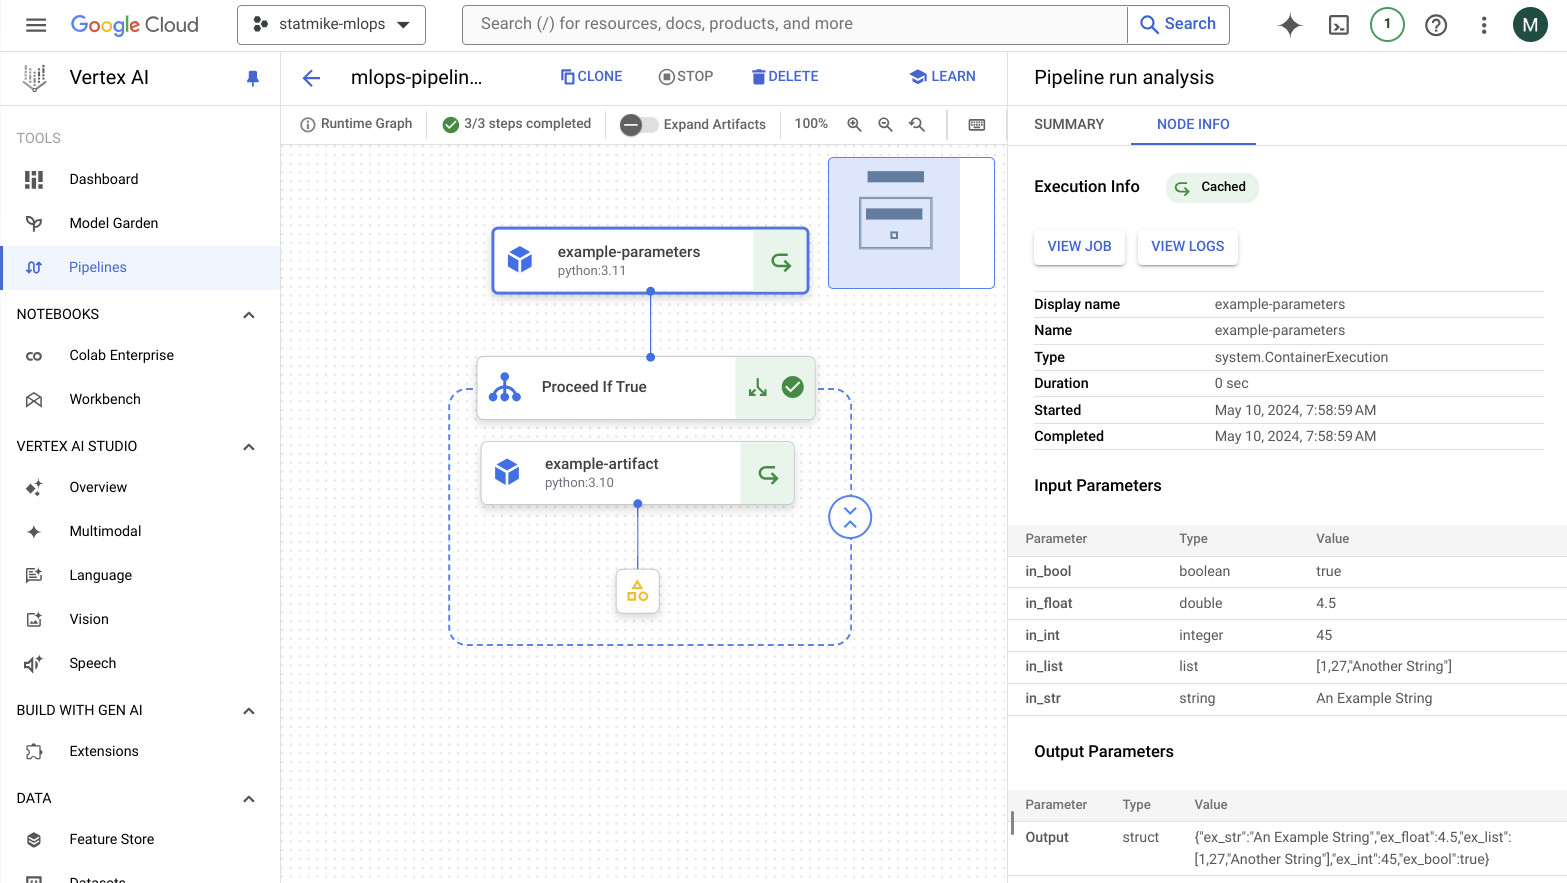
</center><p>

In [40]:
[(task.task_name, task.state) for task in pipeline_job.task_details]

[('mlops-pipeline-intro-20240513162405', 3),
 ('example-parameters', 8),
 ('example-artifact', 8),
 ('condition-1', 3)]

In [41]:
tasks = {task.task_name: task for task in pipeline_job.task_details}

In [105]:
#tasks['example-parameters'].execution.metadata

In [109]:
pipeline_job.to_dict()['jobDetail']['taskDetails'][1]['execution']['metadata']

{'input:in_int': 45.0,
 'input:in_float': 4.5,
 'output:Output': {'ex_bool': True,
  'ex_str': 'An Example String',
  'ex_int': 45.0,
  'ex_list': [1.0, 27.0, 'Another String'],
  'ex_float': 4.5},
 'vmlmd_lineage_integration': {'pipeline_run_component': {'project_id': 'statmike-mlops-349915',
   'location_id': 'us-central1',
   'pipeline_run_id': 'mlops-pipeline-intro-20240510114744',
   'parent_task_names': ['mlops-pipeline-intro-20240510114744'],
   'task_name': 'example-parameters'}},
 'input:in_list': [1.0, 27.0, 'Another String'],
 'input:in_bool': True,
 'input:in_str': 'An Example String',
 'input': None}

### Pipeline IO Artifacts

The pipeline task created from the `example_artifact` component returned an artifact (`kfp.dsl.Artifact`) as output.  Pipelines automatically store artifacts in Vertex AI ML Metadata.

**Pipeline Dashboard View In The Console: Artifact Info**
<p><center>
    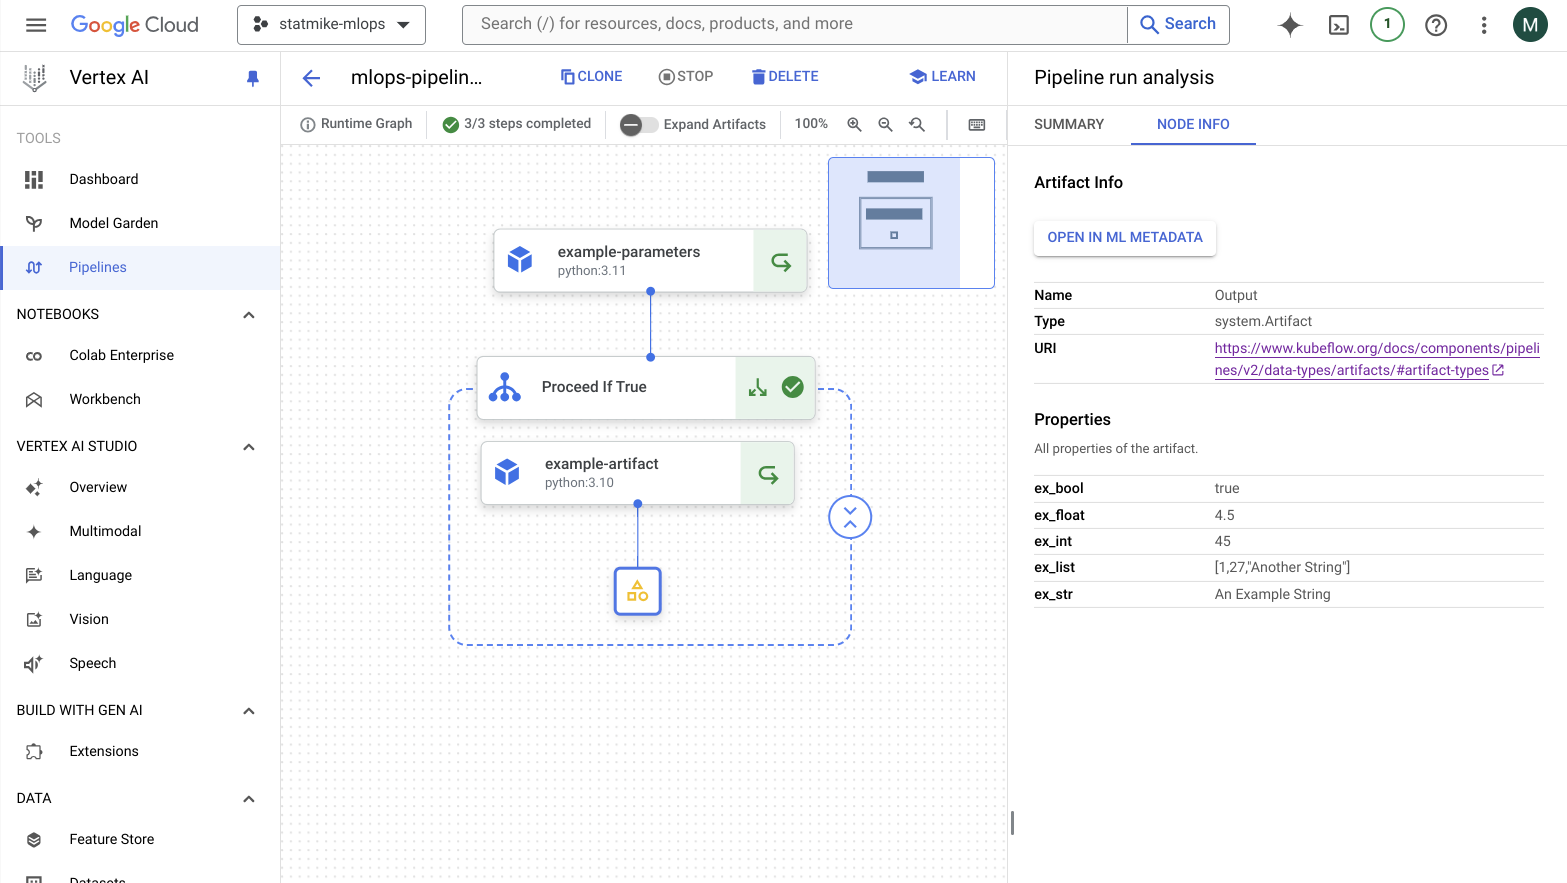
</center><p>

In [111]:
pipeline_job.to_dict()['jobDetail']['taskDetails'][2]['execution']['metadata']

{'vmlmd_lineage_integration': {'pipeline_run_component': {'location_id': 'us-central1',
   'project_id': 'statmike-mlops-349915',
   'task_name': 'example-artifact',
   'pipeline_run_id': 'mlops-pipeline-intro-20240510114744',
   'parent_task_names': ['mlops-pipeline-intro-20240510114744']}},
 'input:metadata': {'ex_str': 'An Example String',
  'ex_list': [1.0, 27.0, 'Another String'],
  'ex_bool': True,
  'ex_int': 45.0,
  'ex_float': 4.5},
 'vertex-ai-pipelines-artifact-argument-binding': {'output:Output': ['projects/1026793852137/locations/us-central1/metadataStores/default/artifacts/17948488352989447493']}}

In [110]:
artifact_id = pipeline_job.to_dict()['jobDetail']['taskDetails'][2]['execution']['metadata']['vertex-ai-pipelines-artifact-argument-binding']['output:Output'][0]
artifact_id

'projects/1026793852137/locations/us-central1/metadataStores/default/artifacts/17948488352989447493'

In [100]:
artifact = aiplatform.Artifact.get(resource_id = artifact)

In [101]:
artifact

resource name: projects/1026793852137/locations/us-central1/metadataStores/default/artifacts/17948488352989447493
uri: https://www.kubeflow.org/docs/components/pipelines/v2/data-types/artifacts/#artifact-types
schema_title:system.Artifact

In [102]:
artifact.uri

'https://www.kubeflow.org/docs/components/pipelines/v2/data-types/artifacts/#artifact-types'

In [112]:
artifact.metadata

{'ex_bool': True,
 'ex_str': 'An Example String',
 'ex_list': [1.0, 27.0, 'Another String'],
 'ex_float': 4.5,
 'ex_int': 45.0}

### Pipeline IO Artifact Metadata Lineage

The consolve view of artifact info include a link to the Vertex AI ML Metadata.  This link can also be directly retrieved for the artifact using the SDK with `lineage_console_uri` attribute.  This ones the lineage view of the artifact in the Vertex AI ML Metadata Console.


**Vertex AI ML Metadata Console: Artifact Lineage**
<p><center>
    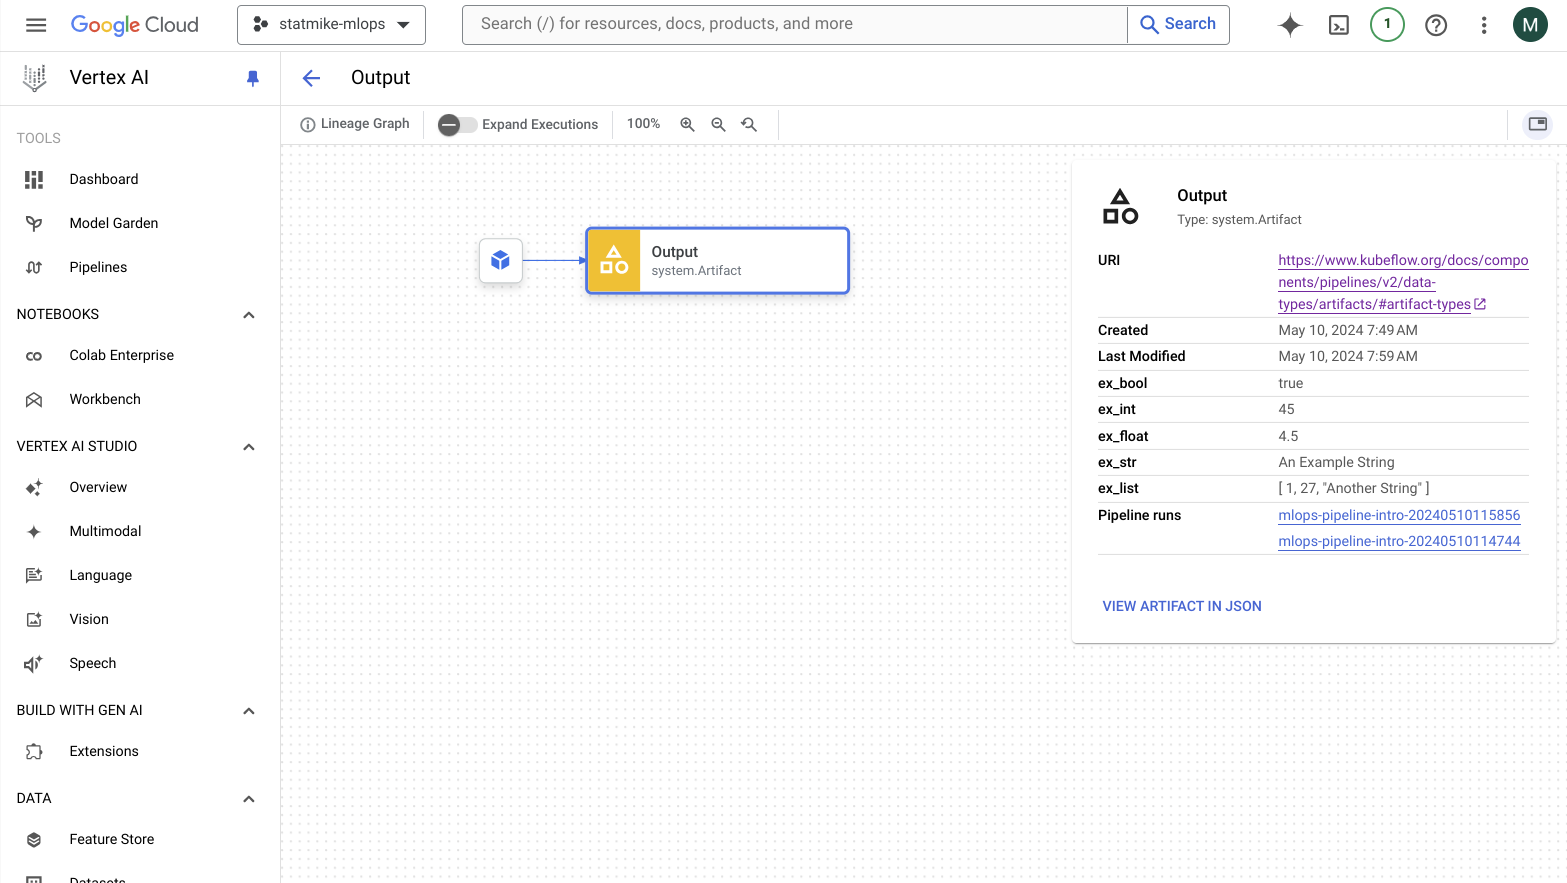
</center><p>

In [103]:
artifact.lineage_console_uri

'https://console.cloud.google.com/vertex-ai/locations/us-central1/metadata-stores/default/artifacts/17948488352989447493?project=statmike-mlops-349915'